In [15]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 单负荷数据集处理
""" class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return x, y """
# 带天气数据的数据集处理
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.load_data = data[:,0,0].reshape(-1, 1)
        self.weather_time_data = data[:,0,1:]
        self.seq_length = seq_length

    def __len__(self):
        return len(self.load_data) - self.seq_length

    def __getitem__(self, index):
        # x为负荷数据和天气数据的拼接，y为负荷数据
        # 负荷数据一列，天气数据五列
        x = self.load_data[index:index + self.seq_length]
        # seq_length<96时天气数据只需取一行
        x_weather = self.weather_time_data[index].reshape(-1,1)
        # print(x.shape, x_weather.shape)
        x = np.concatenate((x, x_weather), axis=0)
        y = self.load_data[index + self.seq_length]
        return x, y



class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


def standardize_data(df):
    return (df - df.mean()) / df.std()

# 读取训练集和验证集的数据
df = pd.read_csv('data/Area1_Weather_Load_copy.csv')
df = df.drop('Time', axis=1)
print(df.describe())
# 对Avg_Temperature Avg_Humidit Rainfall 空缺值进行填充
df['Avg_Temperature'] = df['Avg_Temperature'].ffill()
df['Avg_Humidity'] = df['Avg_Humidity'].ffill()
df['Rainfall'] = df['Rainfall'].ffill()

# 选取训练集和验证集的数据
df = standardize_data(df)
m_all = len(df) # 数据集总行数
m_val = int(0.2*m_all) # 验证集数量
m_test = int(0.2*m_all) # 测试集数量
m_train = m_all - m_test - m_val # 训练集数量

train_df = df.iloc[:m_train]
val_df = df.iloc[m_train:m_train+m_val]
test_df = df.iloc[m_train+m_val:]
print(train_df.shape, val_df.shape, test_df.shape)


               Load  Max_Temperature  Min_Temperature  Avg_Temperature  \
count  26544.000000     26544.000000     26544.000000     26520.000000   
mean    6906.367750        26.406329        19.871519        22.671674   
std     2084.128601         6.392730         6.144009         6.121419   
min     1306.080352         6.200000         3.900000         5.500000   
25%     5359.649104        21.900000        15.300000        18.200000   
50%     6925.499680        27.900000        21.600000        24.500000   
75%     8391.120376        31.700000        25.100000        27.900000   
max    12296.850592        36.700000        28.800000        32.100000   

       Avg_Humidity      Rainfall  
count  26520.000000  26496.000000  
mean      74.142081      5.259149  
std       13.664515     15.244471  
min       21.000000      0.000000  
25%       67.000000      0.000000  
50%       76.000000      0.000000  
75%       84.000000      2.800000  
max       99.000000    236.100000  
(15928, 6

torch.Size([15928, 1, 6]) torch.Size([5308, 1, 6])
(29, 1) torch.Size([1])
Epoch 10/250, Train Loss: 0.0099, Val Loss: 0.0107
Epoch 20/250, Train Loss: 0.0059, Val Loss: 0.0074
Epoch 30/250, Train Loss: 0.0046, Val Loss: 0.0070
Epoch 40/250, Train Loss: 0.0036, Val Loss: 0.0059
Epoch 50/250, Train Loss: 0.0025, Val Loss: 0.0045
Epoch 60/250, Train Loss: 0.0037, Val Loss: 0.0057
Epoch 70/250, Train Loss: 0.0021, Val Loss: 0.0038
Epoch 80/250, Train Loss: 0.0018, Val Loss: 0.0029
Epoch 90/250, Train Loss: 0.0015, Val Loss: 0.0032
Epoch 100/250, Train Loss: 0.0013, Val Loss: 0.0030
Epoch 110/250, Train Loss: 0.0012, Val Loss: 0.0028
Epoch 120/250, Train Loss: 0.0012, Val Loss: 0.0028
Epoch 130/250, Train Loss: 0.0012, Val Loss: 0.0023
Epoch 140/250, Train Loss: 0.0010, Val Loss: 0.0025
Epoch 150/250, Train Loss: 0.0010, Val Loss: 0.0026
Epoch 160/250, Train Loss: 0.0010, Val Loss: 0.0023
Epoch 170/250, Train Loss: 0.0009, Val Loss: 0.0023
Epoch 180/250, Train Loss: 0.0008, Val Loss: 0.002

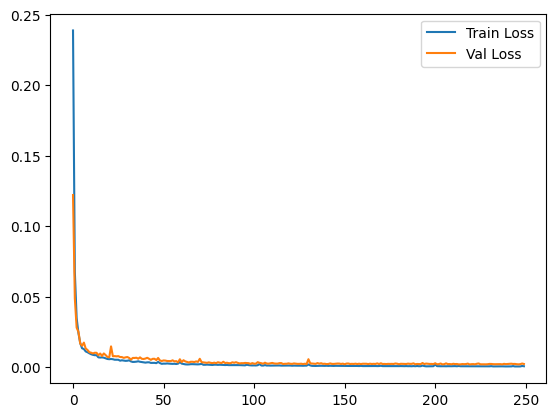

In [16]:
# 将数据集转换为PyTorch的Tensor
train_data = torch.tensor(train_df.values, dtype=torch.float32).unsqueeze(1)
val_data = torch.tensor(val_df.values, dtype=torch.float32).unsqueeze(1)
# 打印训练集和验证集的数据形状
print(train_data.shape, val_data.shape)
# 创建训练集和验证集的数据集对象
seq_length = 24
train_dataset = TimeSeriesDataset(train_data, seq_length)
val_dataset = TimeSeriesDataset(val_data, seq_length)
x,y = train_dataset[0]
print(x.shape, y.shape)
# 创建数据加载器
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 定义模型参数
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1

# 创建模型实例
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 设置训练设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 将模型移动到训练设备
model.to(device)

# 定义训练参数
num_epochs = 250
learning_rate = 0.001

# 定义损失函数和优化器

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 初始化最好的验证集损失
best_val_loss = float('inf')

# 记录train_loss和val_loss
train_loss_list = []
val_loss_list = []

# 记录预测值和真实值
predictions_train = []
# 训练模型
for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    train_loss = 0.0

    for i, (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_loss_list.append(train_loss)
    # 在验证集上进行评估
    model.eval()  # 设置模型为评估模式
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_loss_list.append(val_loss)
    # 每隔10次打印训练结果
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 保存最好的模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

print(f'Best Val Loss: {best_val_loss:.4f}')
# 画出train_loss和val_loss
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.legend()
plt.show()


Test RMSE: 0.0942
Test MAPE: 9.03%


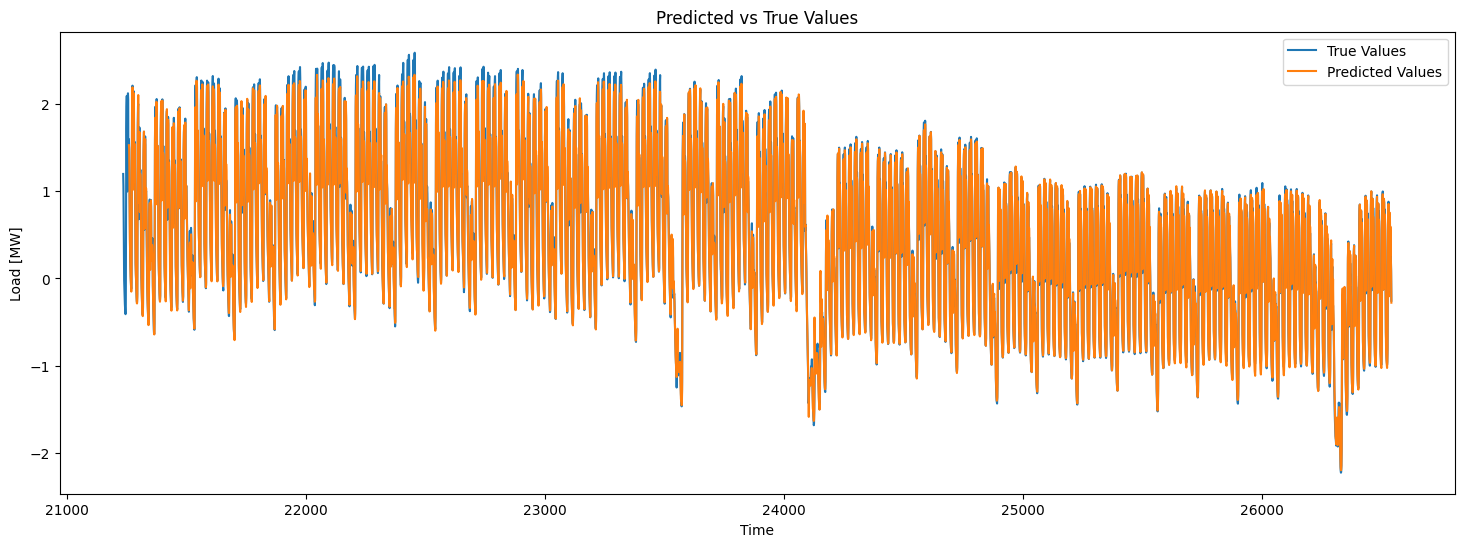

In [18]:
# 将数据集转换为PyTorch的Tensor
test_data = torch.tensor(test_df.values, dtype=torch.float32).unsqueeze(1)

# 创建测试集的数据集对象
seq_length = 24
test_dataset = TimeSeriesDataset(test_data, seq_length)

# 创建数据加载器
batch_size = 32
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 加载已训练好的模型参数
model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()


# 在测试集上进行预测
predictions = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)

        outputs = model(inputs)
        predictions.append(outputs.detach().cpu().numpy())



# 将预测结果转换为一维数组
predictions = np.concatenate(predictions).flatten()

# 计算测试集的RMSE
test_rmse = np.sqrt(np.mean((predictions - test_df['Load'].values[seq_length:]) ** 2))

# 输出RMSE
print(f'Test RMSE: {test_rmse:.4f}')

# 计算测试集的MAPE
test_mape = np.mean(np.abs(predictions - test_df['Load'].values[seq_length:]) / test_df['Load'].values[seq_length:]) * 100

# 输出MAPE
print(f'Test MAPE: {test_mape:.2f}%')

# 绘制预测值和真实值的曲线图
plt.figure(figsize=(18, 6))
plt.plot(test_df.index, test_df['Load'], label='True Values')
plt.plot(test_df.index[seq_length:], predictions, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Load [MW]')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()